[(array([[ -5.40710861, -14.13507334, -13.94789859,  28.6188964 ]]), array([-17.01486765, -28.33800594, -29.77875615,  49.78987454])), (array([[-71.47406027, -69.1771986 ,  -7.34756845, -17.96280387],
       [ 21.90645613,  22.01415812,   2.37750145,   5.81340489],
       [-39.37357205, -38.07711948,  -4.04245488,  -9.88483908],
       [-27.00357209, -24.79890695,  -2.56954539,  -6.28235645]]), array([-281.99906027, -278.86794587,  -29.90316231,  -73.12033635])), (array([[-410.89215947],
       [ 256.31407037],
       [ -31.39182332],
       [   6.89045123]]), array([-1933.60342748]))]


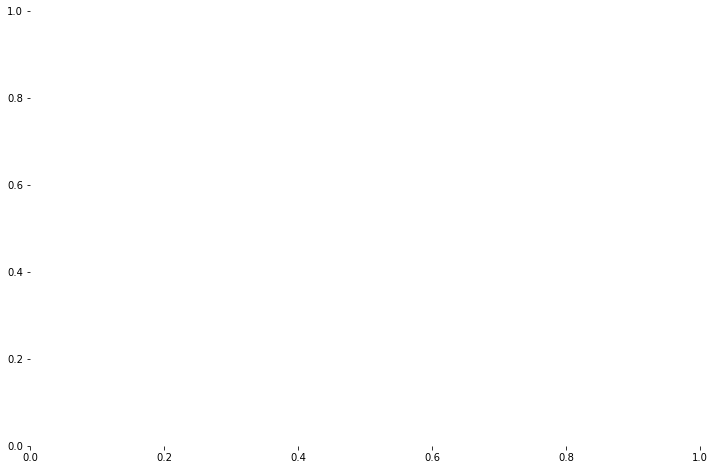

Optimizing network parameters...
Iteration 0 log likelihood -632.784100831
Iteration 1 log likelihood -595.67459126
Iteration 2 log likelihood -560.956758176
Iteration 3 log likelihood -528.65591231
Iteration 4 log likelihood -499.058042201
Iteration 5 log likelihood -472.447625359
Iteration 6 log likelihood -449.096330852
Iteration 7 log likelihood -429.263796971
Iteration 8 log likelihood -413.197006137
Iteration 9 log likelihood -401.115317291
Iteration 10 log likelihood -393.164513396
Iteration 11 log likelihood -389.323687931
Iteration 12 log likelihood -389.258092597
Iteration 13 log likelihood -392.153454392
Iteration 14 log likelihood -396.674491978
Iteration 15 log likelihood -401.24795715
Iteration 16 log likelihood -404.591283679
Iteration 17 log likelihood -406.065436613
Iteration 18 log likelihood -405.655767718
Iteration 19 log likelihood -403.754206953
Iteration 20 log likelihood -400.931457716
Iteration 21 log likelihood -397.768138014
Iteration 22 log likelihood -394.7

In [1]:
from __future__ import absolute_import
from __future__ import print_function
import matplotlib.pyplot as plt

import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.stats.norm as norm
from autograd import grad
from autograd.misc import flatten

from autograd.misc.optimizers import adam

def init_random_params(scale, layer_sizes, rs=npr.RandomState(0)):
    """Build a list of (weights, biases) tuples, one for each layer."""
    return [(rs.randn(insize, outsize) * scale,   # weight matrix
             rs.randn(outsize) * scale)           # bias vector
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]

def nn_predict(params, inputs, nonlinearity=np.tanh):
    for W, b in params:
        outputs = np.dot(inputs, W) + b
        inputs = nonlinearity(outputs)
    return outputs

def log_gaussian(params, scale):
    flat_params, _ = flatten(params)
    return np.sum(norm.logpdf(flat_params, 0, scale))

def logprob(weights, inputs, targets, noise_scale=0.1):
    predictions = nn_predict(weights, inputs)
    return np.sum(norm.logpdf(predictions, targets, noise_scale))

def build_toy_dataset(n_data=80, noise_std=0.1):
    rs = npr.RandomState(0)
    inputs  = np.concatenate([np.linspace(0, 3, num=n_data/2),
                              np.linspace(6, 8, num=n_data/2)])
    targets = np.cos(inputs) + rs.randn(n_data) * noise_std
    inputs = (inputs - 4.0) / 2.0
    inputs  = inputs[:, np.newaxis]
    targets = targets[:, np.newaxis] / 2.0
    return inputs, targets


if __name__ == '__main__':

    init_scale = 0.1
    weight_prior_variance = 10.0
    init_params = init_random_params(init_scale, layer_sizes=[1, 4, 4, 1])

    inputs, targets = build_toy_dataset()

    def objective(weights, t):
        return -logprob(weights, inputs, targets)\
               -log_gaussian(weights, weight_prior_variance)

    print(grad(objective)(init_params, 0))

    # Set up figure.
    fig = plt.figure(figsize=(12,8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    plt.show(block=False)

    def callback(params, t, g):
        print("Iteration {} log likelihood {}".format(t, -objective(params, t)))

        # Plot data and functions.
        plt.cla()
        ax.plot(inputs.ravel(), targets.ravel(), 'bx', ms=12)
        plot_inputs = np.reshape(np.linspace(-7, 7, num=300), (300,1))
        outputs = nn_predict(params, plot_inputs)
        ax.plot(plot_inputs, outputs, 'r', lw=3)
        ax.set_ylim([-1, 1])
        plt.draw()
        plt.pause(1.0/60.0)

    print("Optimizing network parameters...")
    optimized_params = adam(grad(objective), init_params,
                            step_size=0.01, num_iters=1000, callback=callback)